In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import torch
import torchvision
import torch.optim as optim
import argparse
import matplotlib
import torch.nn as nn
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from tqdm.notebook import tqdm
from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision.utils import save_image
import pandas as pd
import numpy as np
matplotlib.style.use('ggplot')
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import RepeatedKFold, cross_val_score
from sklearn.model_selection import KFold
import copy

c:\Users\mdzak\anaconda3\envs\fyp\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Import CSV and merge with drugs

In [2]:
selected_dim = 128
dimension = pd.read_csv('../results/results' + str(selected_dim) + 'D_latent_space_dna_meth.tsv',sep='\t')

In [3]:
cell_line_name = pd.read_csv('../results_clean/cell_line_name_dna_meth.csv')

In [4]:
gdsc_drug = pd.read_csv('../results_clean/gdsc_drug_nodash.csv')

In [5]:
dimension.drop(columns=['Unnamed: 0'], inplace=True)
gdsc_drug.drop(columns=['Unnamed: 0'], inplace= True)

In [6]:
dimension['CELL_LINE_NAME'] = cell_line_name['CELL_LINE']

In [7]:
dimension

,0,1,2,3,4,5,6,7,8,9,...,119,120,121,122,123,124,125,126,127,CELL_LINE_NAME
0,0.257649,0.367905,-0.316169,-2.450200,0.896207,-0.306396,0.040796,-1.562901,-0.191658,-0.303967,...,-0.390880,-1.762449,0.996050,1.685361,0.038959,-1.332917,2.574497,0.663017,-0.766124,dms53
1,-0.485408,0.689928,0.381287,-0.837483,0.192373,-0.574186,-0.865449,0.917400,0.749186,-0.295143,...,1.682005,-0.232119,0.503149,0.706627,0.159365,1.148933,3.465427,-0.159691,0.280858,sw1116
2,0.310404,-0.946017,-0.861003,1.298446,0.304596,-1.072315,0.469882,0.935943,-0.021631,-0.012280,...,0.354510,1.536413,-0.982758,-0.017836,-0.048801,-0.800349,-2.850868,-0.159700,1.119022,p3hr1
3,0.196453,0.840015,0.295631,0.277697,-0.336109,1.279360,-1.097295,0.559683,-0.346177,0.300485,...,-1.126680,-0.166518,0.273345,0.135879,0.692845,1.114507,-2.869138,0.481234,2.813995,hut78
4,-0.243231,0.847392,0.984537,0.481817,-0.105398,0.994923,-0.443648,-0.661769,0.466033,-0.609941,...,0.646114,0.628980,0.254079,0.368022,0.529851,-0.348529,-2.507193,-0.513243,2.655861,umuc3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
838,-0.186357,-0.515294,-1.050231,-0.178011,-1.592714,-0.032956,-0.363624,-0.002767,-0.295767,-0.544842,...,-1.786941,-0.845840,0.441206,-0.669843,-0.316336,-0.003037,1.542336,-0.648602,1.377838,uo31
839,0.679910,-0.143883,-0.445034,0.461096,0.257221,-0.373053,-1.185102,0.578107,-0.662319,-0.305469,...,-0.243613,0.393775,0.560154,0.698871,-0.213210,-1.336929,-2.107328,-0.230628,-0.450253,sf268
840,-0.424310,0.506764,0.655425,0.905986,-0.731646,-1.261937,0.042817,0.535406,-0.291645,-0.384929,...,-0.449366,0.820775,0.203442,0.337288,-0.162978,-0.244286,-0.824387,-0.559017,-2.426988,sf539
841,0.704209,0.452495,-0.399363,0.749073,-1.067308,-1.602799,0.733508,0.263094,0.438836,-0.295644,...,-1.147306,0.318956,0.455772,0.669230,0.437862,0.807621,-1.845123,0.092654,-1.348003,snb75


In [8]:
gdsc_drug

,LN_IC50,CELL_LINE_NAME,DRUG_NAME
0,-1.462148,pfsk1,Camptothecin
1,-4.869447,a673,Camptothecin
2,-3.360684,es5,Camptothecin
3,-5.045014,es7,Camptothecin
4,-3.741620,ew11,Camptothecin
...,...,...,...
242031,10.134495,snu175,N-acetyl cysteine
242032,8.575555,snu407,N-acetyl cysteine
242033,10.520666,snu61,N-acetyl cysteine
242034,10.701430,snuc5,N-acetyl cysteine


In [9]:
dimension_w_drug = pd.merge(dimension, gdsc_drug, on='CELL_LINE_NAME')

In [10]:
dimension_w_drug

,0,1,2,3,4,5,6,7,8,9,...,121,122,123,124,125,126,127,CELL_LINE_NAME,LN_IC50,DRUG_NAME
0,0.257649,0.367905,-0.316169,-2.450200,0.896207,-0.306396,0.040796,-1.562901,-0.191658,-0.303967,...,0.996050,1.685361,0.038959,-1.332917,2.574497,0.663017,-0.766124,dms53,-3.193970,Camptothecin
1,0.257649,0.367905,-0.316169,-2.450200,0.896207,-0.306396,0.040796,-1.562901,-0.191658,-0.303967,...,0.996050,1.685361,0.038959,-1.332917,2.574497,0.663017,-0.766124,dms53,0.868145,Vinblastine
2,0.257649,0.367905,-0.316169,-2.450200,0.896207,-0.306396,0.040796,-1.562901,-0.191658,-0.303967,...,0.996050,1.685361,0.038959,-1.332917,2.574497,0.663017,-0.766124,dms53,3.342054,Cisplatin
3,0.257649,0.367905,-0.316169,-2.450200,0.896207,-0.306396,0.040796,-1.562901,-0.191658,-0.303967,...,0.996050,1.685361,0.038959,-1.332917,2.574497,0.663017,-0.766124,dms53,1.567744,Cytarabine
4,0.257649,0.367905,-0.316169,-2.450200,0.896207,-0.306396,0.040796,-1.562901,-0.191658,-0.303967,...,0.996050,1.685361,0.038959,-1.332917,2.574497,0.663017,-0.766124,dms53,-1.394378,Docetaxel
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139134,-0.966875,0.383040,-0.215750,0.743864,-0.267682,0.622732,0.825473,-0.279673,-0.128047,0.609692,...,0.990979,0.738363,-0.358515,-0.175460,-0.031960,-0.360483,-2.192188,hop92,5.759404,THR-103
139135,-0.966875,0.383040,-0.215750,0.743864,-0.267682,0.622732,0.825473,-0.279673,-0.128047,0.609692,...,0.990979,0.738363,-0.358515,-0.175460,-0.031960,-0.360483,-2.192188,hop92,11.646054,ascorbate (vitamin C)
139136,-0.966875,0.383040,-0.215750,0.743864,-0.267682,0.622732,0.825473,-0.279673,-0.128047,0.609692,...,0.990979,0.738363,-0.358515,-0.175460,-0.031960,-0.360483,-2.192188,hop92,9.336574,glutathione
139137,-0.966875,0.383040,-0.215750,0.743864,-0.267682,0.622732,0.825473,-0.279673,-0.128047,0.609692,...,0.990979,0.738363,-0.358515,-0.175460,-0.031960,-0.360483,-2.192188,hop92,7.010299,alpha-lipoic acid


In [11]:
dimension_w_drug.drop(columns=['CELL_LINE_NAME'],inplace=True)

In [12]:
# selected_dim = 128
# dimension = pd.read_csv('../results/results' + str(selected_dim) + 'D_latent_space_gene_exp.tsv',sep='\t')
# cell_line_name = pd.read_csv('../results_clean/cell_line_name.csv')
# gdsc_drug = pd.read_csv('../results_clean/gdsc_drug_nodash.csv')
# dimension.drop(columns=['Unnamed: 0'], inplace=True)
# gdsc_drug.drop(columns=['Unnamed: 0'], inplace= True)
# dimension['CELL_LINE_NAME'] = cell_line_name['CELL_LINE_NAME']
# dimension_w_drug = pd.merge(dimension, gdsc_drug, on='CELL_LINE_NAME')
# dimension_w_drug.drop(columns=['CELL_LINE_NAME'],inplace=True)
# # dimension_w_drug = pd.get_dummies(dimension_w_drug, columns=['DRUG_NAME'])

In [13]:
dimension_w_drug = dimension_w_drug.sample(frac=1, random_state=33).reset_index(drop=True)
dimension_w_drug

,0,1,2,3,4,5,6,7,8,9,...,120,121,122,123,124,125,126,127,LN_IC50,DRUG_NAME
0,-0.660497,-1.225458,0.298976,-0.572784,-0.607899,0.719592,0.188951,0.251659,-1.018698,-1.290491,...,-0.596631,0.558098,-0.617923,-0.194980,-1.144901,-2.255126,-1.161410,0.863871,-1.671558,AZD8055
1,0.148928,-0.192305,0.207944,-0.325320,0.216569,0.738689,0.305716,0.015035,0.515717,0.665093,...,-0.224585,0.255838,0.708959,0.145579,0.740762,0.876360,0.641892,-1.228383,2.738085,150412
2,-0.537628,0.295881,-0.312474,0.045696,-0.969107,1.286327,-0.381257,0.217041,0.524994,-0.051314,...,-0.187785,-0.505828,-0.085881,0.451674,-0.327806,0.012291,-0.457253,1.272840,1.343824,Taselisib
3,2.113711,-0.433449,-0.216219,0.716303,-0.103957,-1.795534,0.945597,-0.861893,0.410452,-0.578108,...,0.273412,0.500376,0.042380,0.023065,0.802750,-1.075832,-0.111321,-0.259111,5.835869,N30652-18-1
4,0.809540,0.233606,-0.568925,0.388955,-0.047145,-0.758056,1.284933,-1.159245,0.257241,-1.380166,...,-0.560416,0.546079,0.349454,0.232099,-0.527831,-1.049276,0.025659,-2.405237,0.607005,Mycophenolic acid
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139134,0.389052,0.551605,0.748280,0.484167,-0.275389,-2.121249,-0.030644,-0.354845,-0.044124,-1.706383,...,0.828513,-0.542032,-0.540505,-0.130605,-1.141231,1.047644,0.294905,-3.105221,2.131133,GSK-LSD1-2HCl
139135,-1.114373,-0.155593,-0.472478,-0.620802,-0.637903,-0.547858,0.743013,0.854975,-0.235164,0.161446,...,-0.814348,-0.893375,-0.317431,-0.082845,-1.763968,1.759656,0.213867,0.327702,3.109407,Obatoclax Mesylate
139136,0.832460,-1.080370,-0.593841,0.875753,0.931568,-1.333344,0.808531,-0.802226,0.288631,0.054172,...,1.595705,-0.375960,-1.019392,-0.106573,-1.221605,-2.708111,-0.827750,0.452205,1.389483,Cediranib
139137,-0.175985,0.271786,0.062224,-0.222707,0.097327,-0.568416,-0.470046,1.210731,-0.945002,0.482943,...,-0.259105,-0.247450,-1.114933,0.195331,0.526805,-0.526970,0.040478,1.450730,2.507624,RO-3306


### Seperate continuous and categorical columns

In [14]:
cat_cols = ['DRUG_NAME']
cont_cols = dimension_w_drug.drop(columns=['DRUG_NAME', 'LN_IC50']).columns
label_cols = ['LN_IC50']

In [15]:
cont_cols

Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
       ...
       '118', '119', '120', '121', '122', '123', '124', '125', '126', '127'],
      dtype='object', length=128)

In [16]:
cat_cols

['DRUG_NAME']

### Categorify

In [17]:
for cat in cat_cols:
    dimension_w_drug[cat] = dimension_w_drug[cat].astype('category')

In [18]:
dimension_w_drug.dtypes

0             float64
1             float64
2             float64
3             float64
4             float64
               ...   
125           float64
126           float64
127           float64
LN_IC50       float64
DRUG_NAME    category
Length: 130, dtype: object

In [19]:
dimension_w_drug['DRUG_NAME'].head()

0              AZD8055
1               150412
2            Taselisib
3          N30652-18-1
4    Mycophenolic acid
Name: DRUG_NAME, dtype: category
Categories (286, object): ['123138', '123829', '150412', '5-Fluorouracil', ..., 'Zoledronate', 'alpha-lipoic acid', 'ascorbate (vitamin C)', 'glutathione']

In [20]:
dimension_w_drug['DRUG_NAME'].cat.categories

Index(['123138', '123829', '150412', '5-Fluorouracil', '5-azacytidine',
       '50869', '615590', '630600', '667880', '720427',
       ...
       'WZ4003', 'Wee1 Inhibitor', 'Wnt-C59', 'XAV939', 'YK-4-279', 'ZM447439',
       'Zoledronate', 'alpha-lipoic acid', 'ascorbate (vitamin C)',
       'glutathione'],
      dtype='object', length=286)

In [21]:
drug_name = dimension_w_drug['DRUG_NAME'].cat.codes.values

In [22]:
cats = np.stack([drug_name],1)
cats = torch.tensor(cats, dtype=torch.int64)

In [23]:
cats

tensor([[ 37],
        [  2],
        [247],
        ...,
        [ 74],
        [212],
        [ 31]])

### Continuous variables to tensor

In [24]:
conts = np.stack([dimension_w_drug[col].values for col in cont_cols], 1)
conts = torch.tensor(conts, dtype=torch.float)
conts

tensor([[-0.6605, -1.2255,  0.2990,  ..., -2.2551, -1.1614,  0.8639],
        [ 0.1489, -0.1923,  0.2079,  ...,  0.8764,  0.6419, -1.2284],
        [-0.5376,  0.2959, -0.3125,  ...,  0.0123, -0.4573,  1.2728],
        ...,
        [ 0.8325, -1.0804, -0.5938,  ..., -2.7081, -0.8277,  0.4522],
        [-0.1760,  0.2718,  0.0622,  ..., -0.5270,  0.0405,  1.4507],
        [ 0.3520,  0.3775, -0.1903,  ...,  1.2071, -0.4800, -0.4527]])

### Labels to tensor

In [25]:
labels = np.stack([dimension_w_drug[col].values for col in label_cols], 1)
labels = torch.tensor(labels, dtype=torch.float)
labels

tensor([[-1.6716],
        [ 2.7381],
        [ 1.3438],
        ...,
        [ 1.3895],
        [ 2.5076],
        [ 2.9770]])

### Embedding size

In [26]:
cat_szs = [len(dimension_w_drug[col].cat.categories) for col in cat_cols]
emb_szs = [(size, min(50, (size+1)//2)) for size in cat_szs]
emb_szs

[(286, 50)]

### Define model

In [27]:
class TabularModel(nn.Module):

    def __init__(self, emb_szs, n_cont, out_sz, layers, p=0.5):
        super().__init__()
        self.embeds = nn.ModuleList([nn.Embedding(ni, nf) for ni,nf in emb_szs])
        self.emb_drop = nn.Dropout(p)
        self.bn_cont = nn.BatchNorm1d(n_cont)
        
        layerlist = []
        n_emb = sum((nf for ni,nf in emb_szs))
        n_in = n_emb + n_cont
        
        for i in layers:
            layerlist.append(nn.Linear(n_in,i)) 
            layerlist.append(nn.ReLU(inplace=True))
            layerlist.append(nn.BatchNorm1d(i))
            layerlist.append(nn.Dropout(p))
            n_in = i
        layerlist.append(nn.Linear(layers[-1],out_sz))
            
        self.layers = nn.Sequential(*layerlist)
    
    def forward(self, x_cat, x_cont):
        embeddings = []
        for i,e in enumerate(self.embeds):
            embeddings.append(e(x_cat[:,i]))
        x = torch.cat(embeddings, 1)
        x = self.emb_drop(x)
        
        x_cont = self.bn_cont(x_cont)
        x = torch.cat([x, x_cont], 1)
        x = self.layers(x)
        return x

In [28]:
device = torch.device('cuda')
torch.manual_seed(33)
model = TabularModel(emb_szs, conts.shape[1], 1, [200,100], p=0.4).to(device)

In [29]:
model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(286, 50)
  )
  (emb_drop): Dropout(p=0.4, inplace=False)
  (bn_cont): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=178, out_features=200, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=200, out_features=100, bias=True)
    (5): ReLU(inplace=True)
    (6): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.4, inplace=False)
    (8): Linear(in_features=100, out_features=1, bias=True)
  )
)

### Loss and Optimizer Function

In [30]:
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [31]:
torch.cuda.get_device_name(0) # Get name device with ID '0'

'NVIDIA GeForce RTX 3060'

### Perform train/test splits

In [32]:
batch_size = conts.shape[0]
test_size = int(batch_size * .2)

cat_train = cats[:batch_size-test_size]
cat_test = cats[batch_size-test_size:batch_size]
con_train = conts[:batch_size-test_size]
con_test = conts[batch_size-test_size:batch_size]
y_train = labels[:batch_size-test_size]
y_test = labels[batch_size-test_size:batch_size]

#### Try with dataloader

In [33]:
cat_train_l, cat_test_l, y_train_l, y_test_l, con_train_l, con_test_l = train_test_split(cats, labels, conts, test_size=0.2, random_state= 33, shuffle=False)

In [34]:
train_dataset = torch.utils.data.TensorDataset(cat_train_l, con_train_l, y_train_l)
test_dataset = torch.utils.data.TensorDataset(cat_test_l, con_test_l, y_test_l)

In [35]:
batch_size = 256
train_loader = DataLoader(train_dataset, shuffle=False, batch_size = batch_size)
test_loader = DataLoader(test_dataset, batch_size=test_dataset.tensors[0].shape[0])

In [36]:
for cat, con, y in test_loader:
    print(y)

tensor([[ 4.0994],
        [-0.9121],
        [ 6.6825],
        ...,
        [ 1.3895],
        [ 2.5076],
        [ 2.9770]])


In [37]:
con_train_l.shape[1]

128

### Train model

In [38]:
import time
start_time = time.time()
device = torch.device('cuda')
epochs = 100
losses = []


for i in range(epochs):
    i+=1
    best_loss = np.inf
    for cat_train, con_train, y_train in train_loader:
        cat_train = cat_train.to(device)
        con_train = con_train.to(device)
        y_train = y_train.to(device)

        y_pred = model(cat_train, con_train)
        y_pred = y_pred.to(device)
        loss = torch.sqrt(loss_fn(y_pred, y_train))
        if loss.item() < best_loss:
            best_loss = loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    if i%25 == 1:
            print(f'epoch: {i:3}  loss: {best_loss:10.8f}')
    losses.append(best_loss)

print(f'epoch: {i:3}  loss: {loss.item():10.8f}')
print(f'\nDuration: {time.time() - start_time:.0f} seconds')

epoch:   1  loss: 1.77127957
epoch:  26  loss: 1.08074939
epoch:  51  loss: 1.00445557
epoch:  76  loss: 0.95520687
epoch: 100  loss: 1.17885780

Duration: 250 seconds


### Plot loss function

Text(0.5, 0, 'epoch')

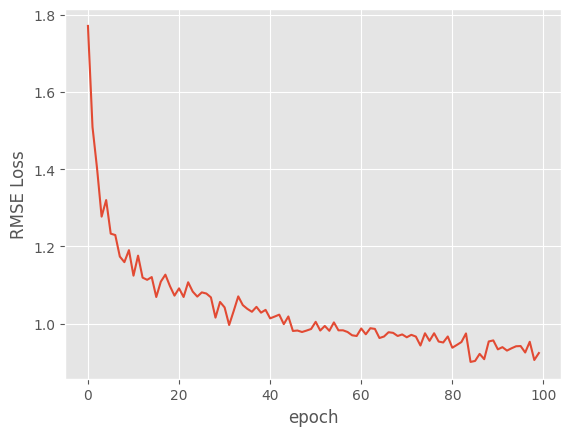

In [39]:
plt.plot(range(epochs), losses)
plt.ylabel('RMSE Loss')
plt.xlabel('epoch')

### Validate Model

In [40]:
with torch.no_grad():
    i = 0
    for cat_test, con_test, y_test in test_loader:
        cat_test = cat_test.to(device)
        con_test = con_test.to(device)
        y_test = y_test.to(device)
        
        y_val = model(cat_test, con_test)
        loss = torch.sqrt(loss_fn(y_val, y_test))
        i += 1
        print(i)
print(f'RMSE: {loss:.8f}')

1
RMSE: 1.19066882


In [41]:
print(f'{"PREDICTED":>12} {"ACTUAL":>8} {"DIFF":>8}')
for i in range(100):
    diff = np.abs(y_val[i].item()-y_test[i].item())
    print(f'{i+1:2}. {y_val[i].item():8.4f} {y_test[i].item():8.4f} {diff:8.4f}')

   PREDICTED   ACTUAL     DIFF
 1.   4.6455   4.0994   0.5461
 2.  -1.7840  -0.9121   0.8719
 3.   4.8439   6.6825   1.8386
 4.   3.2999   1.8101   1.4899
 5.   4.6959   3.9212   0.7747
 6.   5.1515   5.6071   0.4556
 7.   1.5938   2.6574   1.0635
 8.  -3.3793  -2.0265   1.3527
 9.   5.3625   6.1000   0.7376
10.   9.4591  11.0995   1.6404
11.   5.3809   5.7157   0.3348
12.   4.6441   4.5104   0.1337
13.   4.6865   5.6257   0.9392
14.   2.6873   2.8756   0.1884
15.   3.5597   2.8913   0.6684
16.   4.4174   4.3893   0.0281
17.  -3.6572   1.1053   4.7626
18.   4.7971   4.5710   0.2261
19.   6.6975   7.5038   0.8062
20.   5.8626   5.6932   0.1693
21.   4.6746   5.6058   0.9312
22.   0.5366   0.0198   0.5168
23.   6.0206   8.3387   2.3181
24.   2.9755   4.7744   1.7989
25.   1.8002   2.5741   0.7739
26.   4.3313   4.5165   0.1852
27.  -1.9109  -2.7403   0.8294
28.  -0.0021   1.1515   1.1536
29.   5.1529   5.9018   0.7489
30.   3.9543   3.7891   0.1652
31.   0.4337   1.2685   0.8348
32.   4.

### Min Max Scale X and extract y

In [ ]:
scaler = MinMaxScaler()
col = dimension_w_drug.drop(columns=['LN_IC50']).columns
X = scaler.fit_transform(dimension_w_drug.drop(columns=['LN_IC50']))
X = pd.DataFrame(X, columns=col)
y = dimension_w_drug['LN_IC50']

scaled_df = X
scaled_df['LN_IC50'] = y

In [ ]:
scaled_df

## Predictor Portion

### Declare dataset class

In [ ]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self,df):
 
        col = df.drop(columns=['LN_IC50']).columns
        x = df.drop(columns=['LN_IC50'])
        y = df['LN_IC50']
        x = np.array(x)
        y = np.array(y)
    
        self.x_train=torch.tensor(x,dtype=torch.float32)
        self.y_train=torch.tensor(y,dtype=torch.float32)
 
    def __len__(self):
        return len(self.y_train)
   
    def __getitem__(self,idx):
        return self.x_train[idx],self.y_train[idx]

In [ ]:
# declare full dataset
full_dataset = MyDataset(scaled_df)

# split dataset to train and test
dim_np = np.array(scaled_df)
dim_col = scaled_df.columns
train, test = train_test_split(dim_np, train_size=0.8, shuffle=True, random_state=0)
train = pd.DataFrame(train, columns=dim_col)
test = pd.DataFrame(test, columns=dim_col)
# declare train and test dataset
train_dataset = MyDataset(train)
test_dataset = MyDataset(test)

In [ ]:
xgb_x_train = train.drop(columns=['LN_IC50'])
xgb_y_train = train['LN_IC50']

xgb_x_test = test.drop(columns=['LN_IC50'])
xgb_y_test = test['LN_IC50']

### Train with XGBoost

In [ ]:
import xgboost as xgb
xgb_r = xgb.XGBRegressor()
xgb_r.fit(xgb_x_train, xgb_y_train)

y_pred = xgb_r.predict(xgb_x_test)

In [ ]:
y_pred_tensor = torch.tensor(y_pred)
y_tensor = torch.tensor(xgb_y_test)
loss_function = nn.MSELoss()

loss_function(y_pred_tensor, y_tensor).item()


### Declare model class

In [ ]:
import torch.nn as nn
 
class predictor_model(nn.Module):
  def __init__(self):

    super().__init__()

    self.layers = nn.Sequential(
    nn.Linear(414, 64),
    nn.ReLU(),
    nn.Linear(64, 32),
    nn.ReLU(),
    nn.Linear(32, 1)
    )


  def forward(self, x):
    '''Forward pass'''
    return self.layers(x)

### Declare reset weights function for cross validation

In [ ]:
def reset_weights(m):
  '''
    Try resetting model weights to avoid
    weight leakage.
  '''
  for layer in m.children():
   if hasattr(layer, 'reset_parameters'):
    print(f'Reset trainable parameters of layer = {layer}')
    layer.reset_parameters()

### Declare loss function

In [ ]:
loss_function = nn.MSELoss()

### Declare training parameters

In [ ]:
model = predictor_model()
k_folds = 5
n_epochs = 20
torch.manual_seed(0)
batch_size = 10
lr = 0.0001
kfold = KFold(n_splits=k_folds, shuffle = True)
best_mse = np.inf
best_weights = None
history = []
device = torch.device('cuda')
optimizer = torch.optim.Adam(model.parameters(), lr= lr)
model = model.to(device)

### Declare dataloaders

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset,batch_size=batch_size, shuffle=False)

### Declare training function

In [ ]:
def train(model, dataloader):
    count = 0
    model.train()
    current_loss = 0.0
    for i, data in enumerate(dataloader,0):
        x, y = data
        
        x = x.to(device)
        y = y.to(device)

        
        output = model(x)
        loss = loss_function(output, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        current_loss += loss.item()
        count = count + 1

    overall_loss = current_loss/count

    return overall_loss



### Declare validation function

In [ ]:
def validate(model, dataloader):
    count = 0
    model.eval()
    current_loss = 0.0
    with torch.no_grad():
        for i, data in enumerate(dataloader,0):
            x, y = data
        
            x = x.to(device)
            y = y.to(device)

            output = model(x)
            loss = loss_function(output, y)

            current_loss += loss.item()
            count = count + 1

    overall_loss = current_loss/count

    return overall_loss
    

In [ ]:
def validate_new(model, X_test, y_test,best_mse, history,best_weights):
    model.eval()
    output = model(X_test)
    mse = loss_function(output, y_test)
    mse = float(mse)
    history.append(mse)
    if mse < best_mse:
        best_mse = mse
        best_weights = copy.deepcopy(model.state_dict())

    return mse, best_mse, history, best_weights

### Execute Training

In [ ]:
train_loss_list = []
val_loss_list = []
best_mse = np.inf
history = []
best_weights = None
for epoch in range(0, n_epochs):
    print(f'Starting epoch {epoch+1}')

    train_loss = train(model, train_loader)
    train_loss_list.append(train_loss)
    print(f'Training MSE loss for epoch {epoch+1}: ' + str(train_loss))

    X_test = torch.tensor(np.array(xgb_x_test), dtype=torch.float32)
    y_test = torch.tensor(np.array(xgb_y_test), dtype=torch.float32)
    X_test = X_test.to(device)
    y_test = y_test.to(device)
    val_loss, best_mse, history, best_weights = validate_new(model, X_test, y_test, best_mse, history, best_weights)
    val_loss_list.append(val_loss)
    print(f'Validation MSE loss for epoch {epoch+1}: ' + str(val_loss))

In [ ]:
train_loss_list = []
val_loss_list = []

for epoch in range(0, n_epochs):
    print(f'Starting epoch {epoch+1}')

    train_loss = train(model, train_loader)
    train_loss_list.append(train_loss)
    print(f'Training MSE loss for epoch {epoch+1}: ' + str(train_loss))

    val_loss = validate(model, test_loader)
    val_loss_list.append(val_loss)
    print(f'Validation MSE loss for epoch {epoch+1}: ' + str(val_loss))
